### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###

# BCycle Optimization

- Cole Nelson (ctnelson2@wisc.edu)
- Thanasis Pittas (pittas@wisc.edu)
- Asmit Nayak (anayak6@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

BCycle’s mission is to [“offer a rider-centric bike sharing experience with products that work together to make moving around town as fun and convenient as possible.”](https://www.bcycle.com/) BCycle has made itself prominent in the Madison community by offering a fast, convenient way for students and commuters to get around town by using their electric bikes.

BCycles can be checked in and out from any of several docking stations around the city. Riders with a subscription can use the bike for 1.5 hours before having to re-rack the bike at a docking station. Upon re-racking, the rider can (a) be done with their ride, (b) check out a new bike, or (c) check out the same bike again. Failing to re-rack within 1.5 hours charges the rider with additional fees which, being poor graduate students, we seek to avoid.

This introduces an interesting optimization problem. In this project, we seek to provide an optimal route for a client’s BCycle trip, stopping at various points of interest throughout the day. The client specifies a list of points of interest along with a score for each one of them, indicating how interested they are in visiting them. The client also specifies how much time they are willing to spend touring. Since the list of places may be long or they are far apart from each other, in general the client may not be able visit all of them in the given amount of time! We thus seek to provide them with a route that, in that limited amount of time, maximizes the scores of the places visited.


In this report, we develop routes for several points of interest that the client is interested in visiting, such as Union South, Engineering Hall, the Capitol, etc, as well as several BCycle stations along the way. In the final report, this data will be collected from online sources, but for now arbitrary points are chosen. Furthermore, we make some assumptions such as (a) the client is trying to avoid all fees, (b) the client does not want to re-visit a stop, (c) BCycles will always be available and charged at each docking station. We will review these assumptions with our client.

## 2. Mathematical model ##


### Parameters of the Problem
We have a set of $n$ places $\{1,2,\ldots, n\}$ which is partitioned into BCycle docking stations (denote this set by $B$) and points of interest (denote this set by $P$). The user has specified scores $s_1,\ldots, s_n$ for each of these places that quantify how exciting these places are to the user. Let the symmetric matrix $G \in \mathbb{R}^{n \times n}$ with $G_{i,j}$ being equal to the time it takes to go from place $i$ to place $j$. That is, we assume a fully connected graph where the time for each pair of places is given by $G_{i,j}$. Let $s \in \{1,2,\ldots, n\}$ denote the starting node, i.e., the place from which the tour will start and $f \in \{1,2,\ldots, n\}, f \neq s$ be the final node, i.e., the place where the trip must end. The starting node will always be a docking station (in symbols we assume that $s \in B$). 

Let $T$ be the time that the users' subscription allows them to use the bike (this is a constant, which as specified in the introduction will take the value of $90$ minutes). Let $t_{trip}$ denote the maximum duration that the tour can have (this is specified by the user). 

### Optimization Problem in Words

We intend to formulate the following optimization problem: Find a valid tour (in the sense specified below) that maximizes the sum of the scores of the places included in the tour.

By valid, we mean the following: 
* The tour starts from place $s$ and ends in place $f$. 
* The tour visits each place at most once.
* The tour respects the time constraints:
    + The total duration of the tour should be at most the one specified by the user (in our notation $t_{trip}$).
    + Every time the tour visits a docking station, the available time on the BCycle is increased by $T=90$ minutes and it should never be allowed to become negative. 
 


### Formal Description

We formalize the above problem using precise notation.

####  Variables
We start with the variables: We introduce a binary variable $x_{i,j} \in \{0,1\}$ for each pair of places $i,j \in \{1,\ldots, n\}$. We interpret the values as $1$ meaning that the solution tour traverses the edge $(i,j)$ and zero otherwise. We also introduce a variable $t_i$ for each place $i \in \{1,\ldots, n\}$. This is inteded to capture the time that each place is visited in the solution. We finally introduce the variables $bt_i$ for each place $i \in \{1,\ldots, n\}$ that intend to capture the remaining time on the BCycle when place $i$ is visited.

####  Objective Function
For the objective function, we want to maximize the sum of all the scores for the visited places, that is:
$$
\max_{x,t,bt}  \sum_{i=1}^n \sum_{j=1}^n  s_i x_{i,j}
$$

#### Constraint
The first set of constraints say that the tour starts from the place $s$: The first constraint enforces that no edge that goes to $s$ is included in our solution, the second ensures that exactly one outgoing edge is taken, the fourth says that we start at time $t_s=0$ and the last says that we start with zero time remaining in the BCycle (note that the starting place $s$ will always be a docking station so this time will be instantly renewed to $90$ minitues).
* $ \sum_{j \neq s} x_{j,s} = 0$.
* $ \sum_{j \neq s} x_{s,j} = 1$.
* $ t_s = 0$.
* $ {bt}_s = 0$.

The next set of constraints says that our solution should form a simple path:
* $ \sum_{i=1}^n x_{i,k} = \sum_{i=1}^n x_{k,i}$ for all $k \in  \{1,\ldots, n\} \setminus \{s,f\}$.
* $ \sum_{i=1}^n x_{k,i} \leq 1$ for all $k \in  \{1,\ldots, n\} \setminus \{s,f\}$.

We want the diagonal of the matrix $(x_{i,j})$ to be zero, this means that visit nodes twice.
* $x_{i,i} = 0$ for all $i \in  \{1,\ldots, n\}$.


The constraints associated with the fact that the tour must end at place $f$ are the following (the first one says that we should definitely reach node $f$ and the second that we should not continue after reaching it):
* $\sum_{j \neq f} x_{j,f} = 1$.
* $\sum_{j \neq f} x_{f,j} = 0$.

Regarding the time variables, if the edge $(j,i)$ is traversed, we want to make sure that the time $t_i$ is $t_j$ plus the amount of time $G_{j,i}$ needed to travel from node $j$ to node  $i$:
* $t_i \geq t_j + x_{j,i} G_{i,j} -   (1-x_{j,i})(n+1)\max_{i,j}G_{i,j}$  for all $i \neq s,j \neq f$.
The constraint just mentioned examines two cases: if $x_{i,j}=1$ (meaning that the edge is traversed), then  only the first term is active and the timestamp gets increased by the travel time, if on the other hand $x_{i,j}=0$ then only the second term is nonzero and it subtracts a quantity sufficiently large so that it makes the right hand side negative. Given that we already have the non-negativity constraint $t_i \geq 0$, this means that in the second case we don't really impose anything additional.

We similarly update the BCycle time variables:
* ${bt}_i \leq ({bt}_{j} - G_{j,i}) x_{j,i} \mathbb{1}(j \not\in B) + (n+1)(T+max_{i,j}G_{ij})(1-x_{j,i}) + (T - G_{j,i})x_{j,i}\mathbb{1}(j \in  B)$ for all $i \neq s,j \neq f$.
Again, the above  contains the following cases unified in a single constraint:
* If the edge $(j,i)$ is selected and $j$ was not docking station, then the available time on the BCycle must be reduced by the travel time $G_{j,i}$.
* If the edge $(j,i)$ is not selected, we add a large enough quantity that is guaranteed to make the right hand side positive, effectively causing the constraint to be vacuous.
* If the edge $(j,i)$ is selected and $j$ was docking station, then the BCycle time gets renewed to $T=90$ mins and we subtract from this the travel time $G_{j,i}$.


## 3. Solution ##

The code below sets up our City of Madison.

In [1]:
# ENV["GUROBI_HOME"] = "C:\\gurobi951\\win64"
# ENV["GRB_LICENSE_FILE"] = "C:\\gurobi951\\win64\\gurobi.lic"

# using Pkg
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")
# Pkg.add("Distances")

using JuMP
using Gurobi
using DataFrames
using Plots
using LinearAlgebra
using Distances

Cartography!

In [6]:
# BCycle Stations must be listed first.
# Points of Interest must be listed second.
# x_coord y_coord is_poi name
points = [
    -5 +4 false "BCycle Station #1"
    +0 +0 false "BCycle Station #2"
    +1 -1 false "BCycle Station #3"
    -6 -3 false "BCycle Station #4"
    +1 -5 true "Memorial Library"
    -5 +2 true "Wandos"
    -6 +0 true "Eagle Heights"
    -9 +3 true "Engineering Hall"
    -6 -7 true "The Comedy Club"
    +1 +2 true "The Capitol"
]

user_scores = [-1 -1 -1 -1  2 3 4 5 6 7 ]
is_docking = [1 1 1 1 0 0 0 0 0 0 ]

just_coords = hcat(points[:,1], points[:,2])

10×2 Matrix{Int64}:
 -5   4
  0   0
  1  -1
 -6  -3
  1  -5
 -5   2
 -6   0
 -9   3
 -6  -7
  1   2

In [7]:
# Extracts important information from the points matrix
function extract_names_and_points(points=points)
    bcycle_points = Array{Float64}(undef, 0, 2)
    interest_points = Array{Float64}(undef, 0, 2)
    bcycle_names = []
    interest_names = []
    for point in eachrow(points)
        if point[3] # is a point of interest
            interest_points = vcat(interest_points, [point[1] point[2]])
            interest_names = vcat(interest_names, point[4])
        else
            bcycle_points = vcat(bcycle_points, [point[1] point[2]])
            bcycle_names = vcat(bcycle_names, point[4])
        end
    end
    return [bcycle_names, bcycle_points, interest_names, interest_points]
end

extract_names_and_points (generic function with 2 methods)

This provides a nice visualization of the city.

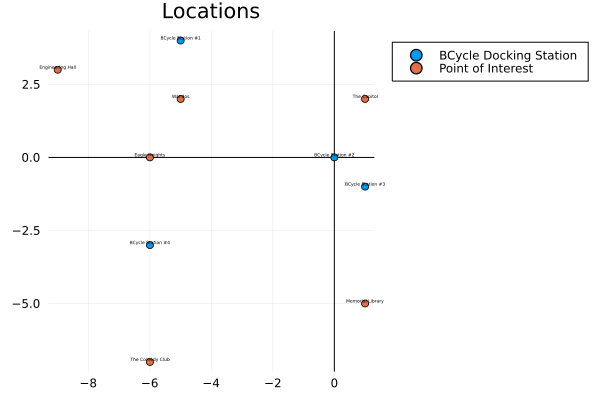

In [8]:
# Creates a nice plot of the city map
function plot_city_map(points=points, with_labels=true)
    (bcycle_names, bcycle_points, interest_names, interest_points) = extract_names_and_points(points)
    if with_labels
        plot(bcycle_points[:,1], bcycle_points[:,2], seriestype = :scatter, title = "Locations", framestyle =:zerolines, labels="BCycle Docking Station", legend=:outertopright, series_annotations=text.(bcycle_names, :bottom, 3))
        plot!(interest_points[:,1], interest_points[:,2], seriestype = :scatter, labels="Point of Interest", series_annotations=text.(interest_names, :bottom, 3)) 
    else
        plot(bcycle_points[:,1], bcycle_points[:,2], seriestype = :scatter, title = "Locations", framestyle =:zerolines, labels="BCycle Docking Station", legend=:outertopright)
        plot!(interest_points[:,1], interest_points[:,2], seriestype = :scatter, labels="Point of Interest") 
    end
end
plot_city_map()

Our solution requires a fully-connected graph. We calculate this based on Euclidean distance.

In [9]:
# Calculates the time between two points as the eucl.
# distance times some constant factor
function calculate_time(point1, point2)
    TIME_FACTOR = (pi)^(pi/2) # produces moderately-long rides
    return euclidean(point1, point2) * TIME_FACTOR
end

# Generates a fully connected graph connection each point
# with their travel time.
function generate_graph(all_points)
    num_points = size(all_points)[1]
    graf = Array{Float64}(undef, num_points, num_points)
    for i in 1:num_points
        for j in 1:num_points
            graf[i,j] = calculate_time(all_points[i,:], all_points[j,:])
        end
    end
    return graf
end

graf = generate_graph(just_coords)
graf

10×10 Matrix{Float64}:
  0.0     38.6646   47.1613   42.6979  …  24.8969  24.8969  66.6962  38.1901
 38.6646   0.0       8.53957  40.5068     36.2303  57.2852  55.6712  13.5023
 47.1613   8.53957   0.0      43.9601     42.6979  65.0355  55.6712  18.1152
 42.6979  40.5068   43.9601    0.0        18.1152  40.5068  24.1536  51.9442
 65.3152  30.7899   24.1536   43.9601     51.9442  77.3291  43.9601  42.2687
 12.0768  32.5177   40.5068   30.7899  …  13.5023  24.8969  54.68    36.2303
 24.8969  36.2303   42.6979   18.1152      0.0     25.6187  42.2687  43.9601
 24.8969  57.2852   65.0355   40.5068     25.6187   0.0     63.0426  60.6851
 66.6962  55.6712   55.6712   24.1536     42.2687  63.0426   0.0     68.8482
 38.1901  13.5023   18.1152   51.9442     43.9601  60.6851  68.8482   0.0

In [10]:
# Extracts and nicely packages the values from the JuMP variables.
function package_soln(first_point, last_point, x, t, btime, n)
    sol_x = zeros(n, n)
    for i=1:n
        for j=1:n
            sol_x[i,j] = JuMP.value(x[i,j])
        end
    end

    sol_t = zeros(n)
    for i=1:n
       sol_t[i] = JuMP.value(t[i])
    end

    sol_btime = zeros(n)
    for i=1:n
       sol_btime[i] = JuMP.value(btime[i])
    end
    return (first_point, last_point, sol_x, sol_t, sol_btime, n)
end

package_soln (generic function with 1 method)

This is what solves our optimization problem!

In [11]:
# Solves the optimization problem.
function solve_my_ride(start_bcycle, end_bcycle, scores, isdocking, graf, max_time, trip_time)

    (bcycle_names, bcycle_points, interest_names, interest_points) = extract_names_and_points(points)
    

    maxd = findmax(graf)[1]
    n = length(graf[:,1])
    first_point = findfirst(x->x==start_bcycle, bcycle_names)
    last_point = findfirst(x->x==end_bcycle, bcycle_names)
    non_first_points = [collect(1:(first_point - 1)); collect((first_point + 1):n)]
    non_last_points = [collect(1:(last_point - 1)); collect((last_point + 1):n)]
    non_end_points = setdiff(collect(1:n), [first_point, last_point])
    

    
    m = Model(with_optimizer(Gurobi.Optimizer, OutputFlag=0))

    # Assignment Matrix
    @variable(m, x[1:n,1:n], Bin)

    # Time (Itinerary) Variable
    @variable(m, t[1:n] >= 0)

    # Remaining time on Bcycle
    @variable(m, btime[1:n] >= 0)

    # Start from node first_point
    @constraint(m, sum( x[j,first_point] for j=non_first_points) == 0)
    @constraint(m, sum( x[first_point,j] for j=non_first_points) == 1)
    @constraint(m, t[first_point] == 0)     # t=0 when we start
    @constraint(m, btime[first_point] == 0) # We start with a zero remaining time on the Bcycle (but starting point is docking station)

    # End at node last_point
    @constraint(m, sum( x[j,last_point] for j=non_last_points) == 1)
    @constraint(m, sum( x[last_point,j] for j=non_last_points) == 0)

    # Do not stay in a node
    for i=1:n
        @constraint(m, x[i,i]==0)
    end

    # Our solution forms a simple path
    for k in non_end_points
        @constraint(m, sum( x[i,k] for i=1:n) == sum( x[k,i] for i=1:n) )
        @constraint(m, sum( x[k,i] for i=1:n) <= 1)
    end

    # Here we can add constraints that say that you should arrive at each node at a specific time window

    # Update time variable
    for i in non_first_points   # i is the node you went
        for j in non_last_points   #j is the node you started
            @constraint(m, t[i] >= t[j] + graf[i,j]*x[j,i] - (n+1)*maxd*(1-x[j,i]))
        end
    end
   

#     # Remaining time on Bcycle gets updated
#     for i in non_first_points  # i is the node you went
#         for j in non_last_points   # j is the node you started
#             @constraint(m, btime[i] <= btime[j] - graf[i,j]*x[j,i]*(1-isdocking[j]) + (n+1)*(maxd + max_time)*(1-x[j,i]) + (max_time-graf[i,j])*x[j,i]*isdocking[j])
#         end
#     end

    # Remaining time on Bcycle gets updated
    for i in non_first_points  # i is the node you are going to
        # A BCycle can only be used for 0-90 minutes
        @constraint(m, 0 <= btime[i] <= max_time)
        for j in non_last_points   # j is the node you are coming from                     
            if graf[j,i] > max_time  # not possible to assign
                @constraint(m, x[j,i] == 0)
            elseif isdocking[j] == 1 # btime is based on a fresh bcycle
                @constraint(m, btime[i] <= (max_time-graf[j,i])*x[j,i] + (max_time+1)*(1-x[j,i]))
                @constraint(m, btime[i] >= (max_time-graf[j,i])*x[j,i])
            else                     # btime is based on a used bcycle
                @constraint(m, btime[i] <= (btime[j]-graf[j,i])*x[j,i] + (max_time+1)*(1-x[j,i]))
                @constraint(m, btime[i] >= (btime[j]-graf[j,i])*x[j,i])
            end
        end
    end

    # Trip must end after trip_time
    @constraint(m, t[last_point] <= trip_time)
    

    @objective(m, Max, sum( sum( scores[i]* x[i,j] for j=1:n) for i=1:n))
    

    @time optimize!(m)
    
    println("Route Finder Status: ", termination_status(m))
    println()
    
    # Nicely package solution.
    return package_soln(first_point, last_point, x, t, btime, n)
end

solve_my_ride (generic function with 1 method)

In [12]:
# Displays a single node in the format
# node_name(time,time_left_on_bcycle)
function display_node(name, t, btime)
    print(name, "(",round(t,digits=2),",",round(btime,digits=2),")")
end

# Displays the solution path.
function display_soln(first_point, last_point, x, t, btime, n, points)
    # This prints the solution (prints the nodes of the path in order)
    println("node_name(time,time_left_on_bcycle)")
    current_node=first_point
    while current_node != last_point
        display_node(points[current_node,4], t[current_node], btime[current_node])
        println()
        print(" -> ")
        for j=1:n
            if j!=current_node && x[current_node,j]>0
                current_node = j
                break
            end

        end
    end
    display_node(points[current_node,4], t[current_node], btime[current_node])
end

display_soln (generic function with 1 method)

## 4. Results and Discussion ##

Recall the scores that the user has specified for each point of interest (the BCycle stations are boring places so by default we will use value -1):

In [67]:
places = ["BCycle Station #1" "BCycle Station #2" "BCycle Station #3" "BCycle Station #4" "Memorial Library" "Wandos" "Eagle Heights" "Engineering Hall" "The Comedy Club" "The Capitol"]
for i=1:10
    println(places[i], " has score ",user_scores[i])
end

BCycle Station #1 has score -1
BCycle Station #2 has score -1
BCycle Station #3 has score -1
BCycle Station #4 has score -1
Memorial Library has score 2
Wandos has score 3
Eagle Heights has score 4
Engineering Hall has score 5
The Comedy Club has score 6
The Capitol has score 7


We demonstrate our solutions in a few selected cases. In all our examples the user wants to start at `BCycle Station #1`, end at `BCycle Station #4`. In our first example, the user has 260 minutes available to tour. As we can see the optimal path found manages to visit all the points of interest. This route includes another two BCycle stations in order for the user to not run out of BCycle time.

In [68]:
# Client Specification
# May take up to 30 seconds to solve.
max_time=90
trip_time=260
soln = solve_my_ride("BCycle Station #4", "BCycle Station #1", user_scores, is_docking, graf,max_time, trip_time)
display_soln(soln..., points)
# We return a route for them.

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-08
  0.125565 seconds (8.38 k allocations: 601.875 KiB)
Route Finder Status: OPTIMAL

node_name(time,time_left_on_bcycle)
BCycle Station #4(0.0,0.0)
 -> The Comedy Club(24.15,65.85)
 -> BCycle Station #3(79.82,10.18)
 -> The Capitol(97.94,71.88)
 -> Wandos(134.17,35.65)
 -> BCycle Station #2(166.69,3.14)
 -> Eagle Heights(202.92,53.77)
 -> Engineering Hall(228.54,28.15)
 -> BCycle Station #1(260.0,3.25)

The next one is an extreme scenario where the user has only 60 minutes available for the trip. The optimal route only allows them to visit two places of interst: Eagle Heights and Wandos.

In [69]:
max_time=90
trip_time=60
soln = solve_my_ride("BCycle Station #4", "BCycle Station #1", user_scores, is_docking, graf,max_time, trip_time)
display_soln(soln..., points)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-08
  0.205924 seconds (9.31 k allocations: 630.781 KiB)
Route Finder Status: OPTIMAL

node_name(time,time_left_on_bcycle)
BCycle Station #4(0.0,0.0)
 -> Eagle Heights(18.12,71.88)
 -> Wandos(31.62,58.38)
 -> BCycle Station #1(60.0,46.31)

Increasing the trip_time by 10 minutes manages to find a slightly better route. This route now replaces Wandos with Engineering Hall, which has higher score.

In [72]:
max_time=90
trip_time=70
soln = solve_my_ride("BCycle Station #4", "BCycle Station #1", user_scores, is_docking, graf,max_time, trip_time)
display_soln(soln..., points)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-08
  0.227386 seconds (9.95 k allocations: 650.938 KiB)
Route Finder Status: OPTIMAL

node_name(time,time_left_on_bcycle)
BCycle Station #4(0.0,0.0)
 -> Eagle Heights(18.12,71.88)
 -> Engineering Hall(43.73,46.27)
 -> BCycle Station #1(70.0,21.37)

## 5. Conclusion ##

This is not to be included in the preliminary report.

## 6. Author Contributions

Note: The contributions in each category must sum to 100%. See Canvas for more details on what type of work belongs in each category.

#### 1. Modelling  
Cole: 33.3%  

Thanasis: 33.3%

Asmit: 33.3%

  
#### 2. Analysis  
Cole: 33.3%  

Thanasis: 33.3%

Asmit: 33.3%


#### 3. Data Gathering  
Cole: 33.3%  

Thanasis: 33.3%

Asmit: 33.3% 


#### 4. Software Implementation  
Cole: 33.3%  

Thanasis: 33.3%

Asmit: 33.3%


#### 5. Report writing and poster presentation   
Cole: 33.3%  

Thanasis: 33.3%

Asmit: 33.3%